# Explicando Previsões de Câncer de Mama com ResNet-50 e Grad-CAM

Este Notebook oferece uma implementação da técnica Grad-CAM (Gradient-weighted Class Activation Mapping) para interpretar as previsões de um modelo de Deep Learning treinado para a classificação de imagens de histopatologia de câncer de mama.

Em domínios de alto risco como a medicina, a confiabilidade e a transparência dos modelos de Inteligência Artificial são cruciais. Modelos como a ResNet-50, apesar de seu alto desempenho, operam como "caixas-pretas", tornando difícil para médicos e pesquisadores confiarem ou validarem suas decisões. O Grad-CAM é uma técnica de IA Explicável (XAI) que visa superar essa barreira, gerando "mapas de calor" (heatmaps) que destacam visualmente as regiões de uma imagem que mais contribuíram para a predição final do modelo.

Neste projeto, o processo é dividido em diferentes etapas:

- Carregamento do Modelo: Uma rede neural ResNet-50, já treinada para classificar imagens como "benignas" ou "malignas", é carregada a partir de um arquivo de pesos.

- Implementação do Grad-CAM: A classe Grad-CAM é construída do zero, demonstrando como usar hooks do PyTorch para extrair os gradientes e as ativações da última camada convolucional.

- Análise de Amostras: A técnica é aplicada a imagens de amostra de ambas as classes (benigna e maligna).

- Visualização e Interpretação: Os resultados são exibidos de forma comparativa, mostrando a imagem original ao lado da mesma imagem com o heatmap sobreposto, permitindo uma análise direta das áreas de interesse que o modelo utilizou para sua classificação.

O objetivo final é transformar uma simples predição em uma resposta visualmente fundamentada, mostrando quais características morfológicas nos tecidos levaram o modelo a essa conclusão e, assim, construindo uma ponte entre o poder da IA e a necessidade de validação clínica.

Importação das bibliotecas necessárias

In [ ]:
import glob
import os
import random
import shutil
from typing import Optional, Tuple, List, Union

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

## Etapa 0: Aquisição e Organização do Dataset

O objetivo desta etapa inicial é preparar os dados, realizando o download do dataset BreakHis e reorganizando sua estrutura de arquivos para um formato adequado.

Download do dataset BreakHis a partir do repositório do Kaggle utilizando a biblioteca kagglehub.

In [ ]:
caminho = kagglehub.dataset_download("ambarish/breakhis")

Abaixo, ocorre a definição das variáveis de caminho para o dataset de origem e para o diretório de destino, que será usado para organizar os dados. Em seguida, a estrutura de pastas de destino é criada, com subdiretórios separados para cada uma das classes do problema ("benign" e "malignant").

In [ ]:
caminho_dados = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
caminho_destino = '/kaggle/working/data'
classes = ['benign', 'malignant']

for classe in classes:
    os.makedirs(os.path.join(caminho_destino, classe), exist_ok=True)

Para simplificar a estrutura do dataset, é criada uma função que navega pela organização original de pastas, a qual é dividida por subtipo, paciente e magnificação. Esta função extrai apenas as imagens com magnificação de 40X, renomeia cada arquivo para garantir sua unicidade e os copia para os diretórios de destino (benign e malignant) previamente criados.

In [ ]:
def copiar_imagens(classe, magnificacao='40X'):
    caminho_dados_sob = os.path.join(caminho_dados, classe, 'SOB')
    caminho_destino_classe = os.path.join(caminho_destino, classe)

    dirs_subtipos = os.listdir(caminho_dados_sob)

    for subtipo in dirs_subtipos:
        caminho_subtipo = os.path.join(caminho_dados_sob, subtipo)

        dirs_pacientes = os.listdir(caminho_subtipo)
        for id_paciente in dirs_pacientes:
            caminho_mag = os.path.join(caminho_subtipo, id_paciente, magnificacao)

            if os.path.isdir(caminho_mag):
                imagens = [f for f in os.listdir(caminho_mag) if f.endswith('.png')]
                for nome_imagem in imagens:
                    arquivo_origem = os.path.join(caminho_mag, nome_imagem)
                    nome_imagem_destino = f"{id_paciente}-{subtipo}-{nome_imagem}"
                    arquivo_destino = os.path.join(caminho_destino_classe, nome_imagem_destino)
                    shutil.copy(arquivo_origem, arquivo_destino)

copiar_imagens('benign')
copiar_imagens('malignant')

## Etapa 1: Configuração do Ambiente e Carregamento do Modelo

Inicialização dos parâmetros do projeto, definição da pipeline de pré-processamento de imagens e carregamento do modelo ResNet-50 treinado a partir de um arquivo de pesos, preparando o ambiente para a análise.

Definição das constantes globais do projeto, como tamanho da imagem, caminho dos pesos e dispositivo de computação (CPU/GPU). Também é criada a sequência de transformações (transformacao_inferencia) para padronizar as imagens de entrada.

In [ ]:
TAMANHO_IMAGEM = 224
CAMINHO_PESOS = "/content/modelo_final_resnet50_breakhis.pth"
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformacao_inferencia = transforms.Compose([
    transforms.Resize((TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Implementação da função carregar_modelo_resnet50, que instancia a arquitetura ResNet-50, adapta sua camada de classificação e carrega os pesos customizados. O bloco de código final executa a função de forma segura, tratando a ausência do arquivo de pesos, e armazena o modelo na variável modelo_carregado.

In [ ]:
def carregar_modelo_resnet50(caminho_pesos: str,
                              device: torch.device = DEVICE,
                              num_classes: int = NUM_CLASSES) -> nn.Module:
    modelo = torchvision.models.resnet50(weights=None)
    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    estado_dict = torch.load(caminho_pesos, map_location=device)

    novo_estado = {}
    for chave, valor in estado_dict.items():
        if chave.startswith("module."):
            novo_estado[chave[len("module."):]] = valor
        else:
            novo_estado[chave] = valor

    modelo.load_state_dict(novo_estado)
    modelo.to(device)
    modelo.eval()
    return modelo

try:
    if not os.path.exists(CAMINHO_PESOS):
        raise FileNotFoundError(f"Arquivo de pesos não encontrado em: {CAMINHO_PESOS}")

    modelo_carregado = carregar_modelo_resnet50(caminho_pesos=CAMINHO_PESOS)
    print("Modelo carregado e pronto para uso.")
except FileNotFoundError as e:
    print(f"AVISO: {e}")
    modelo_carregado = None

Modelo carregado e pronto para uso.


## Etapa 2: Implementação do Grad-CAM

Esta seção contém o código principal para a implementação do Grad-CAM. Inclui uma função auxiliar para localizar a camada convolucional alvo e a classe GradCAM, que encapsula toda a lógica para gerar os mapas de calor (heatmaps) que explicam as previsões do modelo.

Implementação da função encontrar_ultima_camada_conv. Sua finalidade é inspecionar a arquitetura de um modelo PyTorch e identificar automaticamente a última camada convolucional (nn.Conv2d), que é a camada padrão utilizada pelo Grad-CAM para extrair os mapas de características.

In [ ]:
def encontrar_ultima_camada_conv(modelo: nn.Module) -> Tuple[nn.Module, str]:
    camada_alvo = None
    nome_camada_alvo = None
    for nome, modulo in modelo.named_modules():
        if isinstance(modulo, nn.Conv2d):
            camada_alvo = modulo
            nome_camada_alvo = nome
    if camada_alvo is None:
        raise ValueError("Nenhuma camada Conv2d foi encontrada no modelo.")
    return camada_alvo, nome_camada_alvo

Definição da classe GradCAM, que implementa a lógica do algoritmo. A classe utiliza hooks do PyTorch para capturar as ativações (saídas) e os gradientes da camada alvo durante as passagens forward e backward. O método principal __call__ calcula o mapa de calor (suportando as variantes Grad-CAM e Grad-CAM++) e o normaliza. Ao final, uma instância da classe é criada utilizando o modelo carregado na seção anterior.

In [ ]:
class GradCAM:
    def __init__(self, modelo: nn.Module, camada_alvo: Optional[nn.Module] = None):
        self.modelo = modelo
        self.device = next(modelo.parameters()).device
        self.ativacoes = None
        self.gradientes = None
        if camada_alvo is None:
            self.camada_alvo, self.nome_camada_alvo = encontrar_ultima_camada_conv(modelo)
        else:
            self.camada_alvo = camada_alvo
            self.nome_camada_alvo = "especificada manualmente"
        self._registrar_hooks()

    def _registrar_hooks(self):
        def hook_forward(modulo, inp, out): self.ativacoes = out.detach()
        def hook_backward(modulo, grad_in, grad_out): self.gradientes = grad_out[0].detach()
        self.handle_forward = self.camada_alvo.register_forward_hook(hook_forward)
        self.handle_backward = self.camada_alvo.register_full_backward_hook(hook_backward)

    def limpar_hooks(self):
        self.handle_forward.remove()
        self.handle_backward.remove()

    def __call__(self, tensor_entrada: torch.Tensor, classe_alvo: Optional[torch.Tensor] = None, metodo: str = "gradcam") -> np.ndarray:
        self.modelo.zero_grad()
        logits = self.modelo(tensor_entrada)
        if classe_alvo is None: classe_alvo = torch.argmax(logits, dim=1)
        one_hot = F.one_hot(classe_alvo, num_classes=logits.shape[-1]).float()
        logits.backward(gradient=one_hot, retain_graph=False)
        grads, acts = self.gradientes, self.ativacoes
        if metodo.lower() == "gradcam":
            pesos = torch.mean(grads, dim=(2, 3), keepdim=True)
            cam = torch.sum(pesos * acts, dim=1)
        elif metodo.lower() == "gradcam++":
            grads_pow_2 = grads ** 2
            grads_pow_3 = grads ** 3
            sum_acts = torch.sum(acts * grads_pow_3, dim=(2, 3), keepdim=True)
            denom = 2 * grads_pow_2 + sum_acts
            denom = torch.where(denom != 0.0, denom, torch.ones_like(denom))
            alphas = grads_pow_2 / denom
            pesos = torch.sum(alphas * F.relu(grads), dim=(2, 3), keepdim=True)
            cam = torch.sum(pesos * acts, dim=1)
        else: raise ValueError("Método inválido.")
        cam = F.relu(cam).cpu().numpy()
        cams_normalizadas = []
        for mapa in cam:
            mapa -= np.min(mapa)
            if np.max(mapa) > 0: mapa /= np.max(mapa)
            cams_normalizadas.append(mapa)
        return np.stack(cams_normalizadas, axis=0)

if modelo_carregado:
    gradcam = GradCAM(modelo=modelo_carregado)
    print(f"Instância do GradCAM criada. Camada alvo detectada: '{gradcam.nome_camada_alvo}'")
else:
    print("GradCAM não pôde ser instanciado pois o modelo não foi carregado.")
    gradcam = None

Instância do GradCAM criada. Camada alvo detectada: 'layer4.2.conv3'


## Etapa 3: Aplicação do Grad-CAM e Visualização dos Resultados

Nesta seção, as ferramentas implementadas anteriormente são utilizadas para gerar e visualizar as explicações do Grad-CAM. Uma função é definida para sobrepor o mapa de calor à imagem original. Em seguida, um loop processa imagens de amostra, gerando as predições do modelo e os respectivos mapas de calor para análise visual.

Implementação da função aplicar_heatmap_na_imagem. Ela redimensiona o mapa de calor gerado pelo Grad-CAM para as dimensões da imagem original, aplica um mapa de cores (colormap) para facilitar a visualização e, por fim, o sobrepõe à imagem original com um nível de transparência ajustável.


In [ ]:
def aplicar_heatmap_na_imagem(imagem_original: Image.Image,
                               mapa_ativacao: np.ndarray,
                               alpha: float = 0.6) -> np.ndarray:
    img_np = np.array(imagem_original)
    altura, largura = img_np.shape[:2]

    mapa_redimensionado = cv2.resize(mapa_ativacao, (largura, altura))
    heatmap = np.uint8(255 * mapa_redimensionado)
    heatmap_colorido = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_colorido_rgb = cv2.cvtColor(heatmap_colorido, cv2.COLOR_BGR2RGB)

    sobreposicao = np.uint8((1 - alpha) * img_np + alpha * heatmap_colorido_rgb)
    return sobreposicao

Execução do processo de análise e visualização. Um conjunto de imagens de amostra é selecionado e, para cada uma, o modelo realiza uma predição. Em seguida, o Grad-CAM++ é aplicado para gerar um mapa de calor, que é sobreposto à imagem original. Os resultados (imagem original, imagem com heatmap, predição e probabilidades) são exibidos. Ao final do processo, os hooks do Grad-CAM são removidos para liberar recursos.

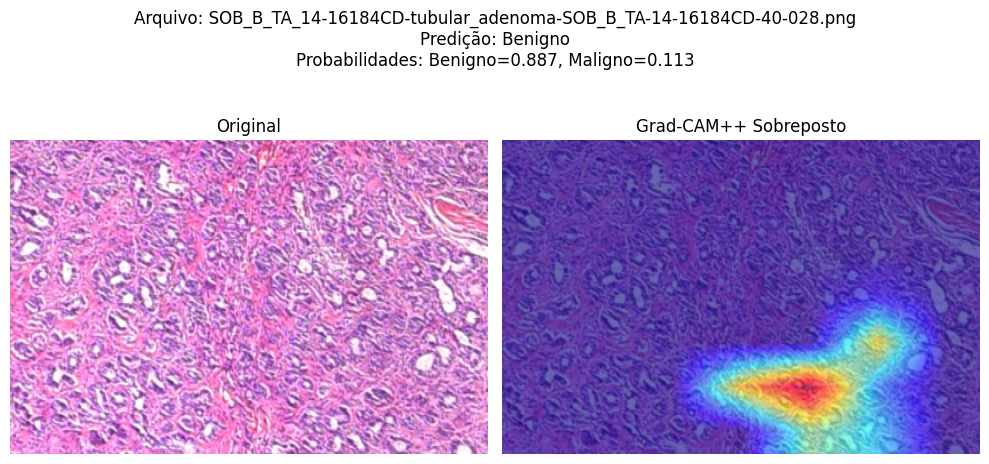

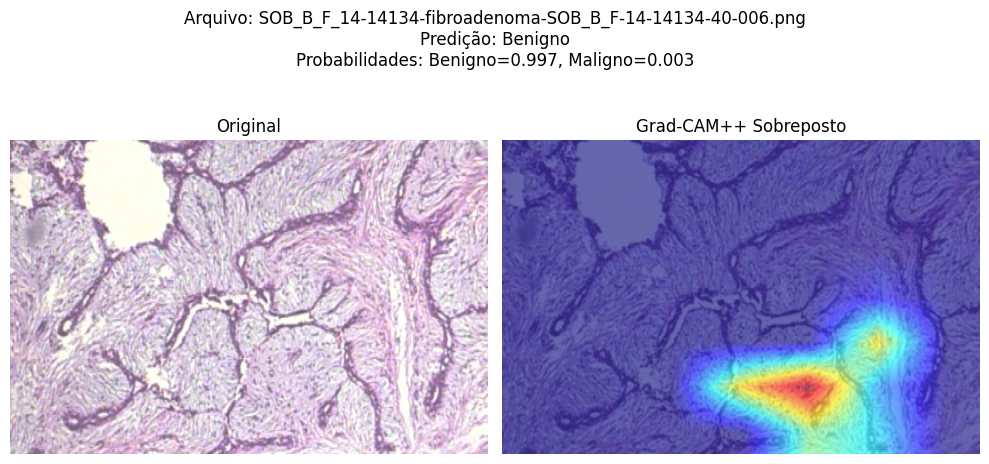

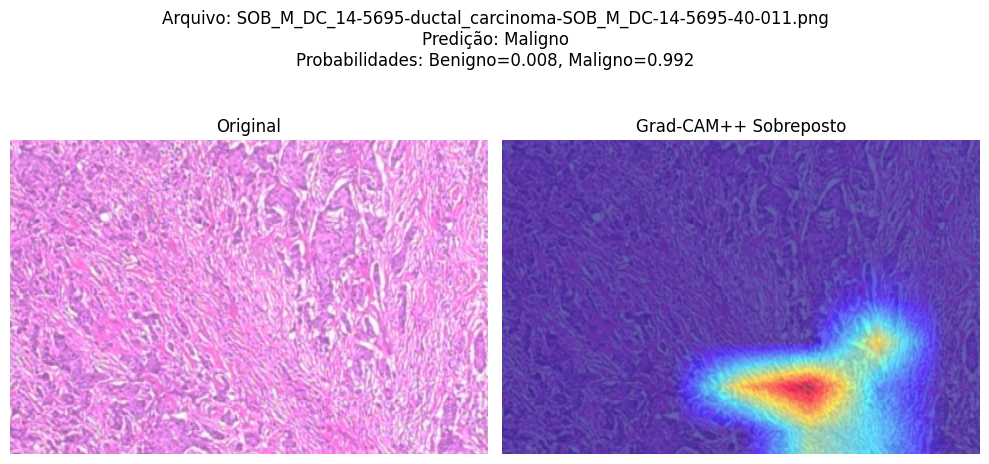

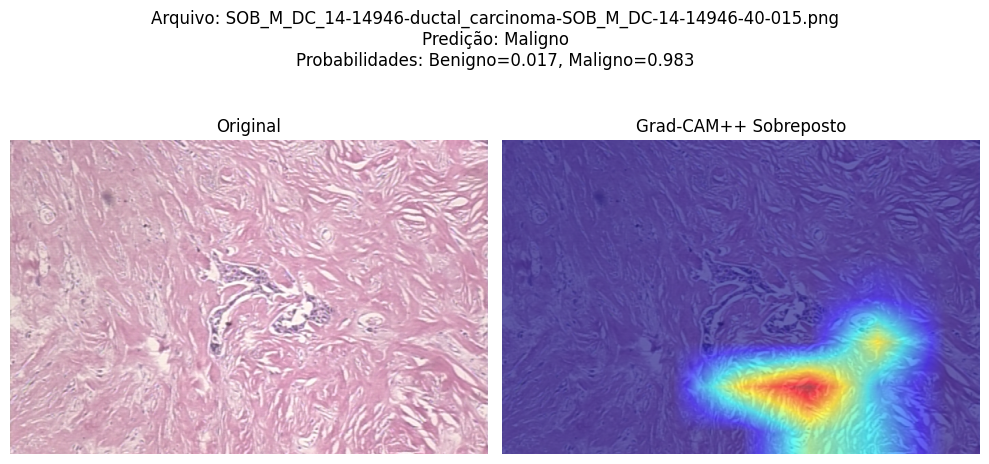


Processo concluído. Hooks do Grad-CAM foram removidos.


In [ ]:
if modelo_carregado and gradcam:
    DIRETORIO_DADOS = '/kaggle/working/data'
    DIRETORIO_BENIGNO = os.path.join(DIRETORIO_DADOS, 'benign')
    DIRETORIO_MALIGNO = os.path.join(DIRETORIO_DADOS, 'malignant')

    try:
        imagens_benignas = glob.glob(os.path.join(DIRETORIO_BENIGNO, '*.png'))
        imagens_malignas = glob.glob(os.path.join(DIRETORIO_MALIGNO, '*.png'))

        amostra_benigna = random.sample(imagens_benignas, 2)
        amostra_maligna = random.sample(imagens_malignas, 2)
        imagens_para_analisar = amostra_benigna + amostra_maligna

    except (ValueError, FileNotFoundError) as e:
        print(f"Erro ao preparar as imagens: {e}")
        imagens_para_analisar = []

    for caminho_img in imagens_para_analisar:
        try:
            imagem_pil = Image.open(caminho_img).convert("RGB")
            tensor_entrada = transformacao_inferencia(imagem_pil).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                logits = modelo_carregado(tensor_entrada)
                probabilidades = torch.softmax(logits, dim=1).cpu().numpy()[0]
                classe_predita = int(torch.argmax(logits, dim=1).item())

            mapa_cam_np = gradcam(tensor_entrada, metodo="gradcam++")[0]

            imagem_sobreposta = aplicar_heatmap_na_imagem(imagem_pil, mapa_cam_np)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(imagem_pil)
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(imagem_sobreposta)
            plt.title("Grad-CAM++ Sobreposto")
            plt.axis("off")

            nome_arquivo = os.path.basename(caminho_img)
            texto_predicao = f"Predição: {'Benigno' if classe_predita == 0 else 'Maligno'}"
            texto_probs = f"Probabilidades: Benigno={probabilidades[0]:.3f}, Maligno={probabilidades[1]:.3f}"
            plt.suptitle(f"Arquivo: {nome_arquivo}\n{texto_predicao}\n{texto_probs}", fontsize=12)

            plt.tight_layout(rect=[0, 0.03, 1, 0.93])
            plt.show()

        except Exception as e:
            print(f"Ocorreu um erro ao processar a imagem {caminho_img}: {e}")

    if 'gradcam' in locals() and gradcam is not None:
        gradcam.limpar_hooks()
        print("\nProcesso concluído. Hooks do Grad-CAM foram removidos.")
else:
    print("Execução pulada pois o modelo ou o objeto GradCAM não foram inicializados.")